In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

In [2]:
color_palettes = ['Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2','Set3',
                  'cubehelix','gnuplot', 'tab10']

sns.set_palette("tab10")
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# Set Dev Mode

In [3]:
DEV_MODE = True

# Load BioBank Components

In [4]:
biobank_data, biobank_index, med_code_mapping = data_tools.load_all_biobank_components(DEV_MODE)

Importing BioBank Index and Data:
Missing 0 biobank index names
UK BioBank Data Loaded.
Size: 9999 rows x 2781 columns
Elapsed time: 3.9675 seconds


Mapping Medical Codes:   0%|          | 0/2018 [00:00<?, ? feature/s]

# Term Searches / Tree Examples

In [5]:
med_code_mapping.build_tree(code_format="1001");

ethnic_background_2.0
├── Asian or Asian British (3)
│   ├── Any other Asian background (3004)
│   ├── Bangladeshi (3003)
│   ├── Indian (3001)
│   └── Pakistani (3002)
├── Black or Black British (4)
│   ├── African (4002)
│   ├── Any other Black background (4003)
│   └── Caribbean (4001)
├── Chinese (5)
├── Do not know (-1)
├── Mixed (2)
│   ├── Any other mixed background (2004)
│   ├── White and Asian (2003)
│   ├── White and Black African (2002)
│   └── White and Black Caribbean (2001)
├── Other ethnic group (6)
├── Prefer not to answer (-3)
└── White (1)
    ├── Any other white background (1003)
    ├── British (1001)
    └── Irish (1002)



In [6]:
med_code_mapping.search_codes("mononucleosis").head()

,coding,meaning,code_format,name
362,1567,infectious mononucleosis / glandular fever / e...,6,illness_code
668,075,075 Infectious mononucleosis,87,cancer_type_ICD9
669,0759,0759 Infectious mononucleosis,87,cancer_type_ICD9
580,B27,B27 Infectious mononucleosis,19,cancer_type_ICD10
581,B270,B27.0 Gammaherpesviral mononucleosis,19,cancer_type_ICD10


In [7]:
index_tools.term_search(biobank_index, "cancer")

['cancer_first_year_age',
 'illness_first_year_age',
 'n_cancers',
 'n_non_cancer_illnesses',
 'cancer_dx',
 'cancer_code',
 'illness_code',
 'cancer_dx_year_interpolated',
 'cancer_dx_age_interpolated',
 'illness_dx_year_interpolated',
 'illness_dx_age_interpolated',
 'cancer_dx_recording_time_method',
 'illness_dx_recording_time_method',
 'cancer_dx_date',
 'cancer_type_ICD10',
 'cancer_dx_age',
 'cancer_occurences',
 'cancer_tumor_histology',
 'cancer_tumor_behavior',
 'cancer_type_ICD9',
 'cancer_report_format']

# Feature Exploration

In [8]:
# feature_data = {"feature": [], "feature_samples": [], "n_unique": []}

# for column in tqdm(biobank_data.columns, desc="Analyzing features", unit=" feature"):
#     unique_features = biobank_data[column].unique()
#     feature_data["feature_samples"].append(np.random.choice(unique_features, min(5, len(unique_features))))
#     feature_data["feature"].append(column)
#     feature_data["n_unique"].append(len(unique_features))
    
# feature_data = pd.DataFrame(feature_data)

# Feature Index EDA

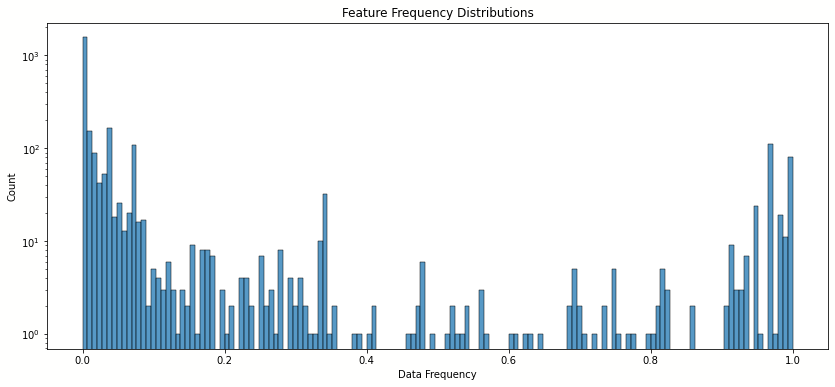

In [9]:
fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.histplot(biobank_index["frequency"], ax=ax)
ax.set_yscale("log")
add_plt_labels(ax, "Data Frequency", "Count", "Feature Frequency Distributions")
plt.show()
fig.tight_layout()
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("feature_frequency_distribution.png"), facecolor="#fffffe")

# actual EDA

In [10]:
cancer_biobank = biobank_data.loc[~biobank_data["cancer_code"].isna()]

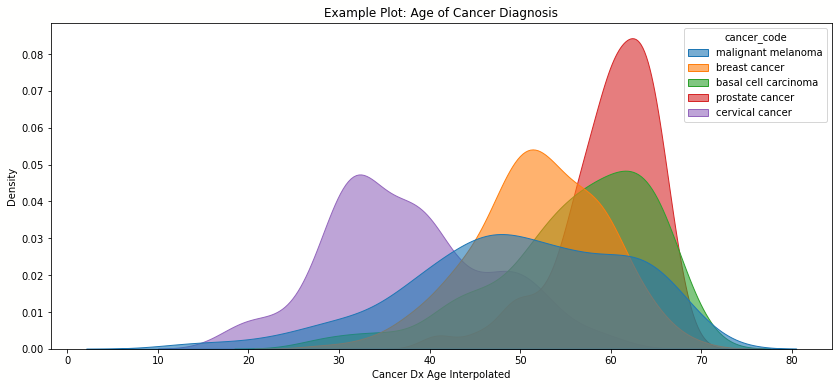

In [11]:
cancer_codes, counts = np.unique(cancer_biobank["cancer_code"], return_counts=True)

common_cancer_codes = cancer_codes[np.argsort(counts,)[-5:]]
common_cancer_biobank = cancer_biobank.loc[cancer_biobank["cancer_code"].isin(common_cancer_codes)]

fig, ax = plt.subplots(figsize=(14, 6), facecolor="#fffffe")
sns.kdeplot(data=common_cancer_biobank, x="cancer_dx_age_interpolated", hue="cancer_code", ax=ax,
            cumulative=False, shade=True, common_norm=False, bw_method=.35, alpha=.6)
ax.set_title("Example Plot: Age of Cancer Diagnosis")
add_plt_labels(ax, "cancer_dx_age_interpolated", "Density")
fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("cancer_dx_age.png"), facecolor="#fffffe")

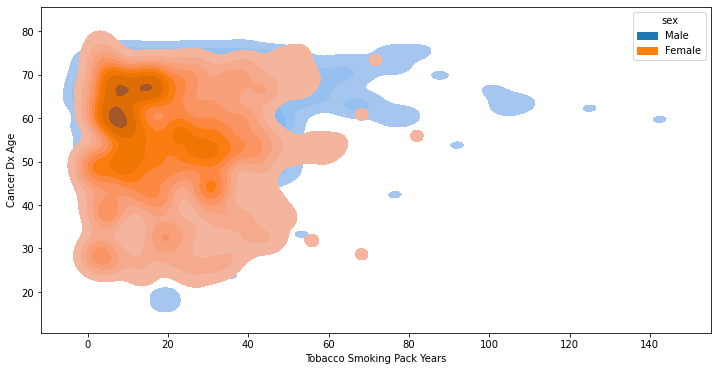

In [12]:
y, x = "cancer_dx_age", "tobacco_smoking_pack_years"

fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=biobank_data, x=x, y=y, hue="sex", ax=ax, fill=True, bw_method=.2)
add_plt_labels(ax, x, y)

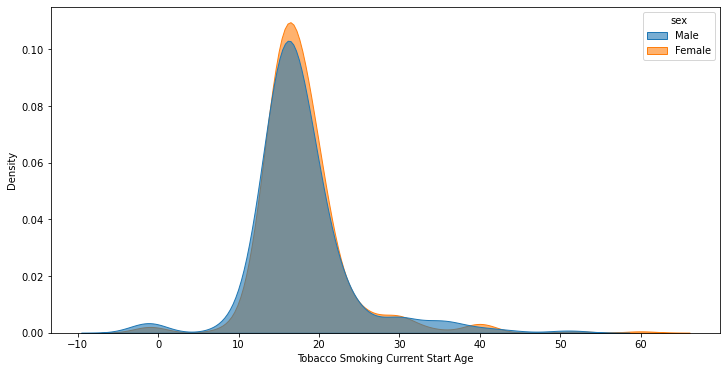

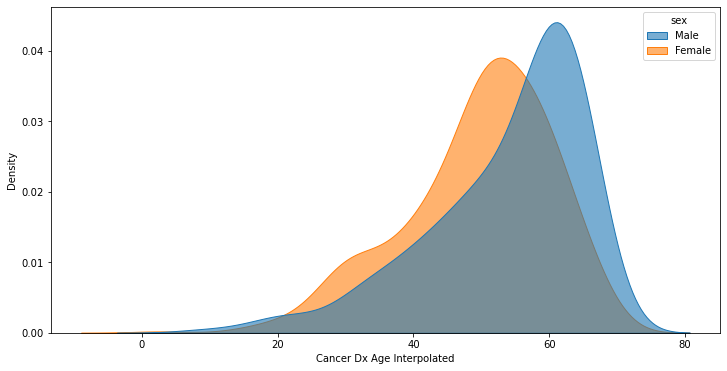

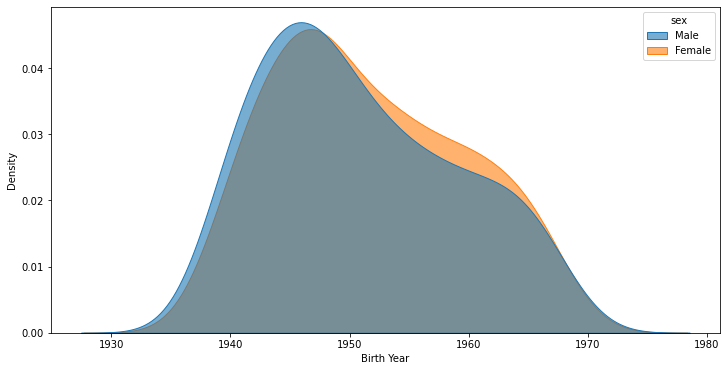

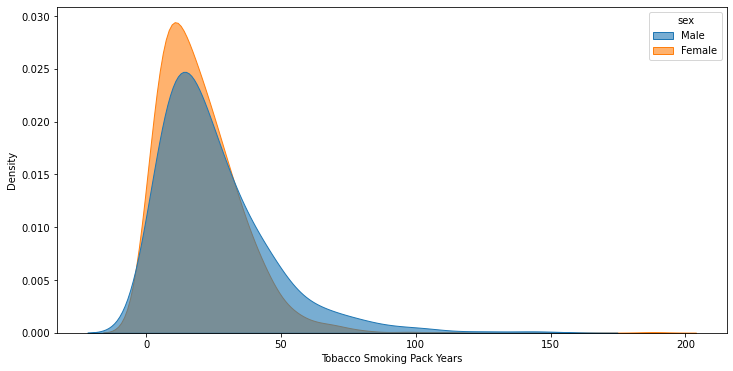

In [13]:
x_s = ["tobacco_smoking_current_start_age", "cancer_dx_age_interpolated",
          "birth_year", "tobacco_smoking_pack_years"]
for x in x_s:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(data=biobank_data, x=x, hue="sex", ax=ax, shade=True, 
                alpha=.6, bw_method=.35, common_norm=False)
    add_plt_labels(ax, x, y="Density")

# Vegetarian Diets

In [18]:
from analysis import *
from utilities import *

{'whiskers': [<matplotlib.lines.Line2D at 0x14e7d4220>,
 'caps': [<matplotlib.lines.Line2D at 0x13d6f57c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14e3d3850>],
 'medians': [<matplotlib.lines.Line2D at 0x1486f7c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x1486f7fa0>],
 'means': []}

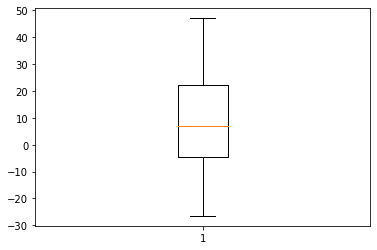

In [31]:
illness_value, illness_dx_ages = get_illness_value_dx_age(biobank_data, "depression", "illness_code")
veg_age = biobank_data["meat_intake_last_age"]
was_veg = ~pd.isnull(veg_age)

plt.boxplot((illness_dx_ages - veg_age)[was_veg & illness_value])

In [43]:
get_multiple_features_from_base_feature(biobank_data, "medications_other_supplements")

['medications_other_supplements',
 'medications_other_supplements_0.1',
 'medications_other_supplements_0.2',
 'medications_other_supplements_0.3',
 'medications_other_supplements_0.4',
 'medications_other_supplements_0.5',
 'medications_other_supplements_1.0',
 'medications_other_supplements_1.1',
 'medications_other_supplements_1.2',
 'medications_other_supplements_1.3',
 'medications_other_supplements_1.4',
 'medications_other_supplements_1.5',
 'medications_other_supplements_2.0',
 'medications_other_supplements_2.1',
 'medications_other_supplements_2.2',
 'medications_other_supplements_2.3',
 'medications_other_supplements_2.4',
 'medications_other_supplements_2.5']

In [44]:
biobank_data["medications_other_supplements"].unique()

array(['Fish oil (including cod liver oil)', 'None of the above',
       'Selenium', 'Glucosamine', 'Calcium', nan, 'Zinc',
       'Prefer not to answer', 'Iron'], dtype=object)

/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

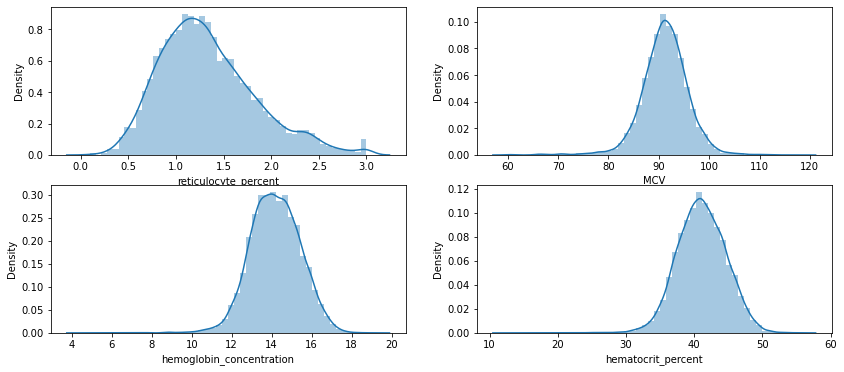

In [73]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=2, nrows=2)
axes = axes.ravel()
sns.distplot(np.clip(biobank_data["reticulocyte_percent"], 0, 3), ax=axes[0])
sns.distplot(biobank_data["MCV"], ax=axes[1])
sns.distplot(biobank_data["hemoglobin_concentration"], ax=axes[2])
sns.distplot(biobank_data["hematocrit_percent"], ax=axes[3])
plt.show()

In [101]:
biobank_data[["reticulocyte_percent", "MCV", "hematocrit_percent", "hemoglobin_concentration",
              "RBC_count", "air_pollution_NOs_2010"]].corr("spearman")

,reticulocyte_percent,MCV,hematocrit_percent,hemoglobin_concentration,RBC_count,air_pollution_NOs_2010
reticulocyte_percent,1.000000,0.048101,0.077398,0.100136,0.049046,0.011204
MCV,0.048101,1.000000,0.117759,0.098633,-0.370218,-0.004060
hematocrit_percent,0.077398,0.117759,1.000000,0.946059,0.849505,0.002145
hemoglobin_concentration,0.100136,0.098633,0.946059,1.000000,0.808702,-0.010671
RBC_count,0.049046,-0.370218,0.849505,0.808702,1.000000,0.004360
air_pollution_NOs_2010,0.011204,-0.004060,0.002145,-0.010671,0.004360,1.000000


<AxesSubplot:ylabel='sleep_duration'>

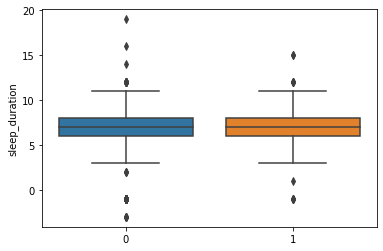

In [122]:
sns.boxplot(data=biobank_data, x=index.values * 1, y="sleep_duration")

/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


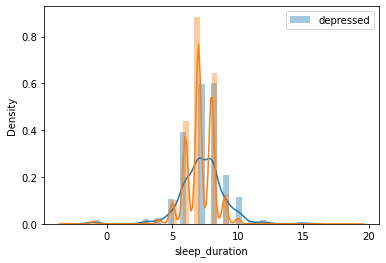

In [121]:
index = get_illness_value(biobank_data, "depression", "illness_code")
sns.distplot(biobank_data["sleep_duration"][index], label="depressed")
sns.distplot(biobank_data["sleep_duration"][~index])
plt.legend()

In [120]:
biobank_data["sleep_duration"]

0       6.0
1       7.0
2       7.0
3       6.0
4       6.0
       ... 
9994    7.0
9995    7.0
9996    8.0
9997    8.0
9998    7.0
Name: sleep_duration, Length: 9999, dtype: float64

In [117]:
index = biobank_data["meat_intake_lamb"] == "Never"
index = biobank_data["insomnia"]
sns.distplot(biobank_data.loc[index]["hemoglobin_concentration"], label="No Lamb")
sns.distplot(biobank_data.loc[~index]["hemoglobin_concentration"], label="Eat Lamb")

KeyError: 'insomnia'

/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/cole/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

<AxesSubplot:xlabel='MCV', ylabel='reticulocyte_percent'>

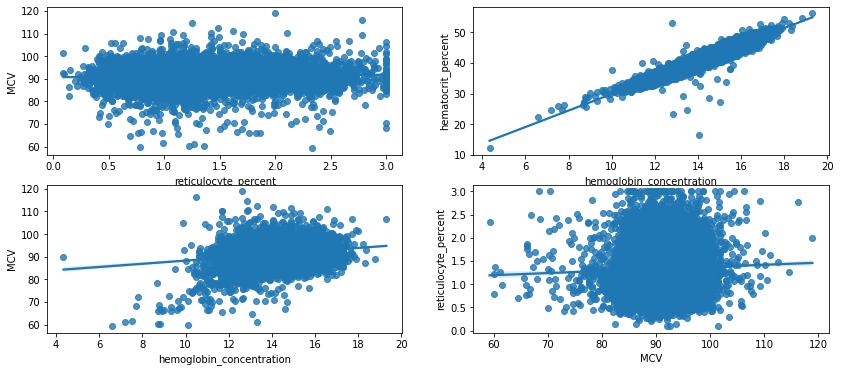

In [81]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=2, nrows=2)
axes = axes.ravel()
sns.regplot(np.clip(biobank_data["reticulocyte_percent"], 0, 3), biobank_data["MCV"], ax=axes[0])
sns.regplot(biobank_data["hemoglobin_concentration"], biobank_data["hematocrit_percent"], ax=axes[1])
sns.regplot(biobank_data["hemoglobin_concentration"], biobank_data["MCV"], ax=axes[2])
sns.regplot(biobank_data["MCV"], np.clip(biobank_data["reticulocyte_percent"], 0, 3), ax=axes[3])

<AxesSubplot:>

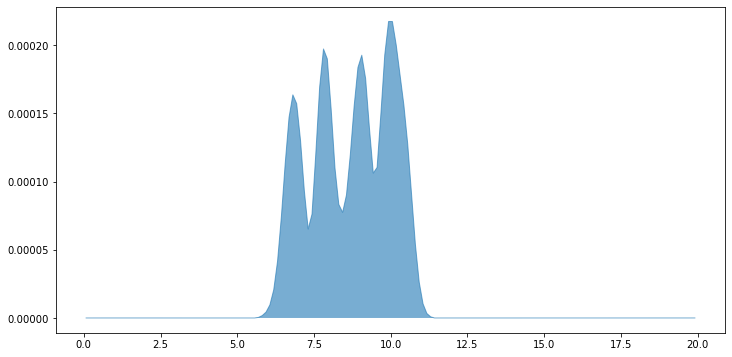

In [50]:
kde_plot(biobank_data["reticulocyte_percent"], bw=0.3, clip=[0, 20])